In [69]:
!pip install geopy

     |████████████████████████████████| 102kB 302kB/s ta 0:00:01
  Created wheel for geographiclib: filename=geographiclib-1.49-cp37-none-any.whl size=35860 sha256=9b27a8b0214c9773209eb5363bc8c48dd4231db356ce73ac4703f192f49dcc3a
  Stored in directory: /home/jovyan/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib


In [99]:
import pandas as pd
import numpy as np
from geopy.distance import vincenty
from geopy import geo_dist

ImportError: cannot import name 'geo_dist' from 'geopy' (/opt/conda/lib/python3.7/site-packages/geopy/__init__.py)

In [17]:
!head gess-master/dummy_gess_sink.log

{"account_id": "a941", "timestamp": "2019-09-16 15:59:43 +0000", "atm": "Halifax", "amount": 200, "location": {"lat": "53.778987", "lon": "-1.529241"}, "transaction_id": "3c407aae-d88a-11e9-91f7-dca9047ee1b6"}
{"account_id": "a941", "timestamp": "2019-09-16 15:51:58 +0000", "atm": "Coop", "amount": 400, "location": {"lat": "53.6399556", "lon": "-1.8560858"}, "transaction_id": "xxx3c407aae-d88a-11e9-91f7-dca9047ee1b6"}
{"account_id": "a679", "timestamp": "2019-09-16 15:59:44 +0000", "atm": "Bradford & Bingley", "amount": 200, "location": {"lat": "53.8670781", "lon": "-1.9090424"}, "transaction_id": "3cb3aab0-d88a-11e9-88fb-dca9047ee1b6"}
{"account_id": "a743", "timestamp": "2019-09-16 15:59:45 +0000", "atm": "RBS", "amount": 200, "location": {"lat": "53.8135182", "lon": "-1.6020819"}, "transaction_id": "3d2708d4-d88a-11e9-942a-dca9047ee1b6"}
{"account_id": "a715", "timestamp": "2019-09-16 15:59:46 +0000", "atm": "Cooperative", "amount": 200, "location": {"lat": "53.8658996", "lon": "-1.

In [359]:
# vectorized haversine function
from math import radians, cos, sin, asin, sqrt, atan2

def haversine_np(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    #print(lat1, lon1, lat2, lon2)
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    #print(a)
    #return earth_radius * 2 * np.arcsin(np.sqrt(a))

    c = [ 2 * atan2(sqrt(x), sqrt(1 - x)) for x in a ]
    distance = [ 6367 * x for x in c ]
    return distance

In [362]:
df = pd.read_json('./gess-master/dummy_gess_sink.log', lines=True)
df = pd.concat([df.drop(['location'], axis=1), df['location'].apply(pd.Series)], axis=1)
list_id = df.account_id.unique()


delta_list = []
dist_list = []
label_list = []
for id_val in list_id:
    #print(id_val)
    df_ = df[df['account_id']==id_val]
    df_ = df_.sort_values(by ='timestamp' )
    df_ = df_.reset_index()
    #display(df_)

    df_['delta'] = (df_['timestamp']-df_['timestamp'].shift()).fillna(0)
    df_.lon = df.lon.astype(float)
    df_.lat = df.lat.astype(float)
    df_['dist'] = haversine_np(df_.lon.shift(), df_.lat.shift(), df_.loc[:, 'lon'], df_.loc[:, 'lat'])
    df_['label'] = np.where((df_['delta'] <= pd.Timedelta(minutes=10)), "NS", "S")
    df_ = df_.sort_index()
    df_ = df_.set_index("index")
    #display(df_)
    delta_list.append(df_["delta"])
    dist_list.append(df_["dist"])
    label_list.append(df_["label"])


df_delta = pd.concat(delta_list).sort_index()
df_dist = pd.concat(dist_list).sort_index()
df_label = pd.concat(label_list).sort_index()

result = pd.concat([df, df_delta, df_dist, df_label], axis=1, sort=False)
display(result)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  app.launch_new_instance()


,account_id,timestamp,atm,amount,transaction_id,lat,lon,delta,dist,label
0,a941,2019-09-16 15:59:43+00:00,Halifax,200,3c407aae-d88a-11e9-91f7-dca9047ee1b6,53.778987,-1.529241,00:07:45,39.467463,NS
1,a941,2019-09-16 15:51:58+00:00,Coop,400,xxx3c407aae-d88a-11e9-91f7-dca9047ee1b6,53.6399556,-1.8560858,00:00:00,NaN,NS
2,a679,2019-09-16 15:59:44+00:00,Bradford & Bingley,200,3cb3aab0-d88a-11e9-88fb-dca9047ee1b6,53.8670781,-1.9090424,00:00:00,NaN,NS
3,a743,2019-09-16 15:59:45+00:00,RBS,200,3d2708d4-d88a-11e9-942a-dca9047ee1b6,53.8135182,-1.6020819,00:00:00,NaN,NS
4,a715,2019-09-16 15:59:46+00:00,Cooperative,200,3d9a2a82-d88a-11e9-8b23-dca9047ee1b6,53.8658996,-1.9073929,00:00:00,NaN,NS
...,...,...,...,...,...,...,...,...,...,...
2488,a102,2019-09-16 16:28:23+00:00,Yorkshire Bank,100,3d28f67d-d88e-11e9-8257-dca9047ee1b6,53.7976765,-1.5359934,00:04:08,34.625899,NS
2489,a873,2019-09-16 16:28:24+00:00,Yorkshire Bank,100,3d9bae45-d88e-11e9-91ee-dca9047ee1b6,53.8794542,-1.7263936,00:07:26,39.467463,NS
2490,a326,2019-09-16 16:28:24+00:00,Santander,100,3e0e846e-d88e-11e9-a904-dca9047ee1b6,53.5702511,-1.7877411,00:01:35,34.422973,NS
2491,a326,2019-09-16 16:23:12+00:00,RBS,100,xxx3e0e846e-d88e-11e9-a904-dca9047ee1b6,53.7616559,-1.5877846,00:13:02,25.902727,S


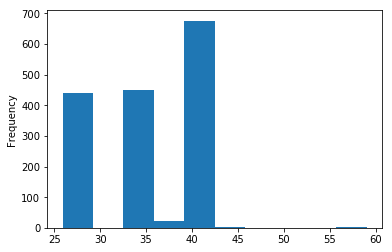

In [365]:
ax = result.dist.plot.hist()

In [341]:
result.dtypes

account_id                     object
timestamp         datetime64[ns, UTC]
atm                            object
amount                          int64
transaction_id                 object
lat                            object
lon                            object
delta                 timedelta64[ns]
dist                          float64
label                          object
dtype: object

In [364]:
result.describe()

,amount,delta,dist
count,2493.000000,2493,1595.000000
mean,174.749298,0 days 00:03:44.022864,34.395360
std,135.775474,0 days 00:04:59.147020,5.716264
min,20.000000,0 days 00:00:00,25.902727
25%,50.000000,0 days 00:00:00,25.902727
50%,100.000000,0 days 00:01:39,34.625899
75%,300.000000,0 days 00:05:53,39.467463
max,400.000000,0 days 00:27:53,59.048483


In [ ]:
result.loc[(result['dist'] >= A)]